<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/custom_bert3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 7.8MB/s 
     |████████████████████████████████| 1.1MB 8.2MB/s 
     |████████████████████████████████| 1.2MB 29.2MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 645kB 38.8MB/s 
     |████████████████████████████████| 706kB 51.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 358kB 44.2MB/s 
     |████████████████████████████████| 174kB 36.0MB/s 


In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)


Mounted at /content/mnt


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [5]:
# data=pd.read_csv('./Peterpan_emo3.csv')
# data=data.dropna(how='any')
# print(f'Dimensions: {data.shape}')
# data

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3189 files belonging to 3 classes.
Using 2552 files for training.
Found 3189 files belonging to 3 classes.
Using 637 files for validation.
Found 60 files belonging to 3 classes.


In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'Leave the carcass.'
Label : 1 (Neg)


# BERT

In [8]:
# sentences=data['sentence'].tolist()
# Y_data= data['posNeg3'].tolist()
# preprocess = hub.load(PREPROCESS_MODEL)
# bert = hub.load(BERT_MODEL)
# inputs = preprocess(sentences[:500])
# bert_results = bert(inputs)

In [9]:
# print(bert_results.keys())

In [10]:
# # pooled_output 은 각 입력 시퀀스를 전체로 나타냅니다. 
# # 모양은 [batch_size, H] 입니다. 이것은 전체 data에 대한 임베딩으로 생각할 수 있습니다.
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

# #sequence_output 은 컨텍스트의 각 입력 토큰을 나타냅니다. 
# # 모양은 [batch_size, seq_length, H] 입니다. 
# # 이것을 data의 모든 토큰에 대한 문맥 삽입으로 생각할 수 있습니다. 
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [12]:
# classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

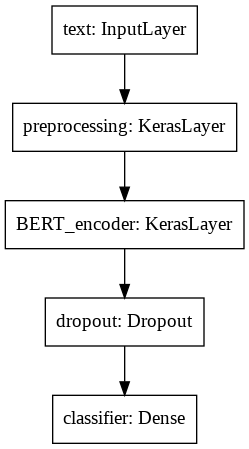

In [13]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [14]:
! pip install -q tf-models-official
from official.nlp import optimization

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {BERT_MODEL}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/20
2552/2552 [==============================] - 1189s 459ms/step - loss: 0.2583 - binary_accuracy: 0.4912 - val_loss: -2.6517 - val_binary_accuracy: 0.5542
Epoch 2/20
2552/2552 [==============================] - 227s 89ms/step - loss: -1.6992 - binary_accuracy: 0.5433 - val_loss: -3.7166 - val_binary_accuracy: 0.5604
Epoch 3/20
2552/2552 [==============================] - 230s 90ms/step - loss: -5.2592 - binary_accuracy: 0.5876 - val_loss: -5.2717 - val_binary_accuracy: 0.5432
Epoch 4/20
2552/2552 [==============================] - 230s 90ms/step - loss: -8.9937 - binary_accuracy: 0.6194 - val_loss: -6.3926 - val_binary_accuracy: 0.5636
Epoch 5/20
 645/2552 [======>.......................] - ETA: 2:44 - loss: -10.5824 - binary_accuracy: 0.7197

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')



In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')